긍정, 부정 분류를 위한 감정분석 모델 KoBERT

라이브러리 출처 : https://github.com/SKTBrain/KoBERT
코드 참고 : https://velog.io/@dev-junku/KoBERT-%EB%AA%A8%EB%8D%B8%EC%97%90-%EB%8C%80%ED%95%B4
           https://velog.io/@seolini43/KOBERT%EB%A1%9C-%EB%8B%A4%EC%A4%91-%EB%B6%84%EB%A5%98-%EB%AA%A8%EB%8D%B8-%EB%A7%8C%EB%93%A4%EA%B8%B0-%ED%8C%8C%EC%9D%B4%EC%8D%ACColab


In [ ]:
# 필요한 라이브러리 다운로드
!pip install tqdm
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
%cd Mecab-ko-for-Google-Colab
!bash install_mecab-ko_on_colab190912.sh

In [2]:
# 모듈 호출
import pandas as pd 
from tqdm import tqdm
import numpy as np
from konlpy.tag import Mecab
from sklearn.model_selection import train_test_split

In [ ]:
# 20만 네이버 리뷰데이터, 별 4,5개 -> 긍정(1) 별 1,2개 -> 부정(0) 표현
df=pd.read_csv("/content/naver_shopping.csv")
del df['Unnamed: 0']

# for i in tqdm(range(len(df))):
#     if (df.loc[i,'label']==4) or (df.loc[i,'label']==5):
#         df.loc[i,'label']=1
#     else:
#         df.loc[i,'label']=0
df

In [37]:
# 불용어 사전 및 자음만 있는 한글등 데이터 전처리

stop_word=set()
with open("/content/stop_word.txt", "r",encoding="UTF-8") as f:
    for line in f:
        stop_word.add(line.strip())
        
for word in stop_word:
    df['text'] = df['text'].str.replace(word," ")
        
df['text'] = df['text'].str.replace(r"[a-zA-Z]"," ")
df['text'] = df['text'].str.replace(r"[^가-힣]"," ")
df['text'] = df['text'].str.replace(r"\s+"," ")
df['text'] = df['text'].str.strip()

df['text']=df['text']

df['text'].nunique()
df.drop_duplicates(subset=['label'], inplace=True)

<ipython-input-37-b36b68f089e2>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['text'] = df['text'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")


label                                               text
0      1                                            배공빠르고 굿
1      0                      택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고
2      1  아주좋아요 바지 정말 좋아서개 더 구매했어요 이가격에 대박입니다 바느질이 조금 엉성...
3      0  선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다 전화...
4      1                   민트색상 예뻐요 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ

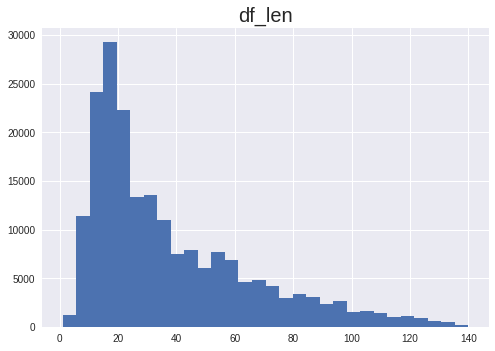

네이버 쇼핑 리뷰의 최대 길이 : 140
네이버 쇼핑 리뷰의 평균 길이 : 37.829275142809855
전체 샘플 중 길이가 80 이하인 샘플의 비율: 90.02863720027484


In [6]:
# 문장의 길이 확인하기
import matplotlib.pyplot as plt
plt.style.use('seaborn')

df_len = [len(x) for x in df['text']]


plt.title('df_len', fontsize=20)
plt.hist(df_len, bins=30)

plt.show()

count = 0
for sentence in df['text']:
    if(len(sentence) <= 80):
        count = count + 1

print('네이버 쇼핑 리뷰의 최대 길이 :',max(len(review) for review in df['text']))
print('네이버 쇼핑 리뷰의 평균 길이 :',sum(map(len, df['text']))/len(df['text']))        
print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(80, (count / len(df['text']))*100))

In [ ]:
!pip install git+https://git@github.com/SKTBrain/KoBERT.git@master

from kobert.utils import get_tokenizer
from kobert.pytorch_kobert import get_pytorch_kobert_model

from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup

!pip install mxnet
!pip install gluonnlp pandas tqdm
!pip install sentencepiece
!pip install transformers==3.0.2
!pip install torch

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gluonnlp as nlp
import numpy as np
from tqdm import tqdm, tqdm_notebook

device = torch.device("cuda:0")

In [8]:
bertmodel, vocab = get_pytorch_kobert_model()

/content/Mecab-ko-for-Google-Colab/.cache/kobert_v1.zip[██████████████████████████████████████████████████]
/content/Mecab-ko-for-Google-Colab/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece[██████████████████████████████████████████████████]


In [39]:
# koBERT모델 넣기 전, 데이터 인코딩

data_list = []
for q, label in tqdm(zip(df['text'], df['label'])):
    data = []
    data.append(q)
    data.append(str(label))

    data_list.append(data)

199391it [00:00, 317141.46it/s]


In [10]:
from sklearn.model_selection import train_test_split
                                             
dataset_train, dataset_test = train_test_split(data_list, test_size=0.2, random_state=42)

In [11]:
class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, max_len,
                 pad, pair):
        transform = nlp.data.BERTSentenceTransform(
            bert_tokenizer, max_seq_length=max_len, pad=pad, pair=pair)

        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    def __len__(self):
        return (len(self.labels))

In [12]:
max_len = 80
batch_size = 64
warmup_ratio = 0.1
num_epochs = 5
max_grad_norm = 1
log_interval = 200
learning_rate =  5e-5

In [13]:
tokenizer = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)

data_train = BERTDataset(dataset_train, 0, 1, tok, max_len, True, False)
data_test = BERTDataset(dataset_test, 0, 1, tok, max_len, True, False)

using cached model. /content/Mecab-ko-for-Google-Colab/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


In [14]:
train_dataloader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, num_workers=5)
test_dataloader = torch.utils.data.DataLoader(data_test, batch_size=batch_size, num_workers=5)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:478: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [15]:
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes=2,   ##클래스 수 조정##
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate
                 
        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)
    
    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)
        
        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device))
        if self.dr_rate:
            out = self.dropout(pooler)
        return self.classifier(out)

In [16]:
#BERT 모델 불러오기
model = BERTClassifier(bertmodel,  dr_rate=0.5).to(device)

#optimizer와 schedule 설정
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

t_total = len(train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)

scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)

#정확도 측정을 위한 함수 정의
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc
    
train_dataloader

In [17]:
for e in range(num_epochs):
    train_acc = 0.0
    test_acc = 0.0
    model.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        train_acc += calc_accuracy(out, label)
        if batch_id % log_interval == 0:
            print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
    print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))
    
    model.eval()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        test_acc += calc_accuracy(out, label)
    print("epoch {} test acc {}".format(e+1, test_acc / (batch_id+1)))

<ipython-input-17-480b6a139979>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):


  0%|          | 0/2493 [00:00<?, ?it/s]

epoch 1 batch id 1 loss 0.6940378546714783 train acc 0.5625
epoch 1 batch id 201 loss 0.5087344646453857 train acc 0.6128731343283582
epoch 1 batch id 401 loss 0.33510029315948486 train acc 0.7428304239401496
epoch 1 batch id 601 loss 0.29159197211265564 train acc 0.7937551996672213
epoch 1 batch id 801 loss 0.2247483730316162 train acc 0.8221363920099876
epoch 1 batch id 1001 loss 0.30918729305267334 train acc 0.8407842157842158
epoch 1 batch id 1201 loss 0.1462634652853012 train acc 0.8526228143213989
epoch 1 batch id 1401 loss 0.2050144225358963 train acc 0.8612821199143469
epoch 1 batch id 1601 loss 0.13747814297676086 train acc 0.8686075109306683
epoch 1 batch id 1801 loss 0.14801010489463806 train acc 0.8748525124930594
epoch 1 batch id 2001 loss 0.1114196702837944 train acc 0.8793181534232883
epoch 1 batch id 2201 loss 0.21190713346004486 train acc 0.8835046569741026
epoch 1 batch id 2401 loss 0.1294252574443817 train acc 0.8867854539775094
epoch 1 train acc 0.8881054452466908


<ipython-input-17-480b6a139979>:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_dataloader)):


  0%|          | 0/624 [00:00<?, ?it/s]

epoch 1 test acc 0.9322523179945055


  0%|          | 0/2493 [00:00<?, ?it/s]

epoch 2 batch id 1 loss 0.25630509853363037 train acc 0.921875
epoch 2 batch id 201 loss 0.31238043308258057 train acc 0.923896144278607
epoch 2 batch id 401 loss 0.17149388790130615 train acc 0.9260442643391521
epoch 2 batch id 601 loss 0.2877732217311859 train acc 0.9267366888519135
epoch 2 batch id 801 loss 0.18662795424461365 train acc 0.9279416354556804
epoch 2 batch id 1001 loss 0.3078881800174713 train acc 0.9289928821178821
epoch 2 batch id 1201 loss 0.13749338686466217 train acc 0.9291345753538718
epoch 2 batch id 1401 loss 0.1244947537779808 train acc 0.9294365631691649
epoch 2 batch id 1601 loss 0.14815859496593475 train acc 0.929955886945659
epoch 2 batch id 1801 loss 0.15982118248939514 train acc 0.9311927401443643
epoch 2 batch id 2001 loss 0.09236219525337219 train acc 0.9315967016491754
epoch 2 batch id 2201 loss 0.3064115047454834 train acc 0.9325306678782371
epoch 2 batch id 2401 loss 0.10665538161993027 train acc 0.9329576218242399
epoch 2 train acc 0.933056307661452

  0%|          | 0/624 [00:00<?, ?it/s]

epoch 2 test acc 0.9329784798534799


  0%|          | 0/2493 [00:00<?, ?it/s]

epoch 3 batch id 1 loss 0.2822840213775635 train acc 0.90625
epoch 3 batch id 201 loss 0.20214229822158813 train acc 0.9386660447761194
epoch 3 batch id 401 loss 0.16102537512779236 train acc 0.9403054862842892
epoch 3 batch id 601 loss 0.23137810826301575 train acc 0.9393978785357737
epoch 3 batch id 801 loss 0.16391748189926147 train acc 0.9408746878901373
epoch 3 batch id 1001 loss 0.25068262219429016 train acc 0.9415896603396603
epoch 3 batch id 1201 loss 0.09074712544679642 train acc 0.9415981473771857
epoch 3 batch id 1401 loss 0.07216627895832062 train acc 0.9427417915774446
epoch 3 batch id 1601 loss 0.10501167178153992 train acc 0.9435704247345409
epoch 3 batch id 1801 loss 0.10374456644058228 train acc 0.9449437812326485
epoch 3 batch id 2001 loss 0.06916818022727966 train acc 0.9457380684657671
epoch 3 batch id 2201 loss 0.2445574253797531 train acc 0.9465086892321672
epoch 3 batch id 2401 loss 0.11460578441619873 train acc 0.9471314035818409
epoch 3 train acc 0.947214701163

  0%|          | 0/624 [00:00<?, ?it/s]

epoch 3 test acc 0.933511475503663


  0%|          | 0/2493 [00:00<?, ?it/s]

epoch 4 batch id 1 loss 0.20019103586673737 train acc 0.9375
epoch 4 batch id 201 loss 0.21910203993320465 train acc 0.9528140547263682
epoch 4 batch id 401 loss 0.1503901332616806 train acc 0.9555018703241895
epoch 4 batch id 601 loss 0.21159614622592926 train acc 0.9542429284525791
epoch 4 batch id 801 loss 0.10299038141965866 train acc 0.9556608926342073
epoch 4 batch id 1001 loss 0.2132888287305832 train acc 0.9566683316683317
epoch 4 batch id 1201 loss 0.07342471182346344 train acc 0.9566767277268943
epoch 4 batch id 1401 loss 0.03791046142578125 train acc 0.9574522662384012
epoch 4 batch id 1601 loss 0.04454922303557396 train acc 0.9583853841349157
epoch 4 batch id 1801 loss 0.06643040478229523 train acc 0.9594496113270405
epoch 4 batch id 2001 loss 0.04846304655075073 train acc 0.9599184782608695
epoch 4 batch id 2201 loss 0.18266205489635468 train acc 0.9605789981826443
epoch 4 batch id 2401 loss 0.10592680424451828 train acc 0.9608756768013328
epoch 4 train acc 0.9608591556357

  0%|          | 0/624 [00:00<?, ?it/s]

epoch 4 test acc 0.9350424965659341


  0%|          | 0/2493 [00:00<?, ?it/s]

epoch 5 batch id 1 loss 0.142694354057312 train acc 0.953125
epoch 5 batch id 201 loss 0.165983647108078 train acc 0.9629197761194029
epoch 5 batch id 401 loss 0.09665527939796448 train acc 0.9660224438902744
epoch 5 batch id 601 loss 0.1465587615966797 train acc 0.9657861896838602
epoch 5 batch id 801 loss 0.048146482557058334 train acc 0.96687734082397
epoch 5 batch id 1001 loss 0.1916045993566513 train acc 0.967111013986014
epoch 5 batch id 1201 loss 0.04482597857713699 train acc 0.9672538509575354
epoch 5 batch id 1401 loss 0.011268195696175098 train acc 0.9675678087080657
epoch 5 batch id 1601 loss 0.08960103243589401 train acc 0.9681253903810119
epoch 5 batch id 1801 loss 0.055510882288217545 train acc 0.9689582176568573
epoch 5 batch id 2001 loss 0.0351376011967659 train acc 0.9690701524237881
epoch 5 batch id 2201 loss 0.189672589302063 train acc 0.9694244093593821
epoch 5 batch id 2401 loss 0.09064587205648422 train acc 0.9694658475635152
epoch 5 train acc 0.969339149618933


  0%|          | 0/624 [00:00<?, ?it/s]

epoch 5 test acc 0.9345095009157509


In [21]:
## 학습 모델 저장
PATH = '/content/model/' # google 드라이브 연동 해야함. 관련코드는 뺐음
torch.save(model, PATH + 'KoBERT.pt')  # 전체 모델 저장
torch.save(model.state_dict(), PATH + 'model_state_dict.pt')  # 모델 객체의 state_dict 저장
torch.save({
    'model': model.state_dict(),
    'optimizer': optimizer.state_dict()
}, PATH + 'all.tar')  # 여러 가지 값 저장, 학습 중 진행 상황 저장을 위해 epoch, loss 값 등 일반 scalar값 저장 가능

In [86]:
# 실험
df=pd.read_csv("/content/neg.csv")
del df['Unnamed: 0']
df

review  \
0   처음 배송왔을 때 제품상자가 심하게 눌리고 찌그러진채로 와서 교환을 받았습니다.하지...   
1   배송온 보통이고 무엇보다 벌크라 그런가  박스가 아주 허접한 박스에 담아져 옵니다....   
2   처음 구매한 로지텍인데 싼티가 너무 나요. 그냥 장난감같은 느낌. 브랜드값으로 이돈...   
3   ^^포장을 개판으로 해놔서 박스가 다 찌그러졌네요찌그러진 박스 받을 생각이면 누가 ...   
4   물건은 모르겠고 택배사때문에 기분드러워요15일에 배달출발한대서 기다렸더니 17일 새...   
5   제품박스에있는 시리얼넘버랑 마우스에있는 시리얼넘버랑 다름. 마우스 뒷면 시리얼넘버로...   
6   좌우 클릭 압력이 달라요 좌클릭은 보통인데 우클릭은 아주 민감한지 살짝만 눌러도 클...   
7   다나와에서 왜 여기가 정품으로 링크된건지 화나네요받고나서야 벌크인걸 확인합니다벌크살...   
8   피시방서 많이 쓰는 제품이라고 그래서 샀더니 넘 별로에요.더블클릭도 자주 되고ㅠ가격...   
9   이번달에만 g마텟 200만원넘게 이용했는데 짭을 파는지 정품을 파는지 관심도 없고 ...   
10    박스가 찌그러져서 찢어져서 왔던데 새상품이 맞는지도 모르겠어요마우스 작동은 잘 되네요   
11  마우스에 불필요한 불빛과 열이 전해져서 전기료나  날 더우면 몸이 더 덥게 생겼네요...   
12          마우스 그지같아요사용하다가보면 간혈적으로 마우스 포인터가 떨려요되게 거슬림   
13       로지택705 쓰다가 이걸 쓰려니 너무 느리고 불편하네요왜그런지 이유를 모르겠네요   

                                            mall_logo         date    name  \
0   //img.danawa.com/cmpny_info/images/TH201_logo.gif  2023.01.03.  su****   
1   //img.danawa.com/cmpny_info/images/TH201_logo.gif  2021.07.14.  ss****   
2   //img.danawa.com/cmpny_info/images/EE715_logo.gif  2021.10.22.  ka****   
3   //img.danawa.com/cmpny_info/images/TH201_logo.gif  2022.06.30.  sh****   
4   //img.danawa.com/cmpny_info/images/EE715_logo.gif  2021.04.17.  kh****   
5   //img.danawa.com/cmpny_info/images/TH201_logo.gif  2021.06.15.  rl****   
6   //img.danawa.com/cmpny_info/images/TH201_logo.gif  2021.06.06.  so****   
7   //img.danawa.com/cmpny_info/images/TH201_logo.gif  2021.07.21.  xo****   
8   //img.danawa.com/cmpny_info/images/EE128_logo.gif  2021.05.21.  ok****   
9   //img.danawa.com/cmpny_info/images/EE128_logo.gif  2021.07.15.  k#****   
10  //img.danawa.com/cmpny_info/images/EE128_logo.gif  2022.12.20.  eu****   
11  //img.danawa.com/cmpny_info/images/TH201_logo.gif  2021.03.05.  mo****   
12  //img.danawa.com/cmpny_info/images/TH201_logo.gif  2022.10.20.  an****   
13  //img.danawa.com/cmpny_info/images/EE715_logo.gif  2021.09.08.  ls****   

    star_score  label  
0           40      0  
1           20      0  
2           40      0  
3           20      0  
4           20      0  
5           20      0  
6           40      0  
7           20      0  
8           20      0  
9           20      0  
10          20      0  
11          20      0  
12          20      0  
13          20      0

In [87]:
df['review'] = df['review'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
df['review'].replace('', np.nan, inplace=True)

df['review'].nunique()
df.drop_duplicates(subset=['review'], inplace=True)

<ipython-input-87-6e063603fabb>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df['review'] = df['review'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")


In [94]:
data_list=[]
for i in df['review']:
    data = []
    data.append(str(i))
    data.append(3)

    data_list.append(data)

In [95]:
data_list

[['처음 배송왔을 때 제품상자가 심하게 눌리고 찌그러진채로 와서 교환을 받았습니다하지만 이번에는 배송은 잘 왔는데 왼쪽버튼에 하자가 있네요 유격이 있어서 좌우로 덜그럭 거리면서 눌리는데 엄청 거슬립니다 보통 마우스는 좌클릭을 많이 사용하는데 교환까지 한 번 받은 제품이 이러니 진짜 아쉽네요',
  3],
 ['배송온 보통이고 무엇보다 벌크라 그런가  박스가 아주 허접한 박스에 담아져 옵니다 로지텍 박스가 아예 없네요 다나와에서 정품 링크를 타고 들어와서 대충보고 산 제 잘못도 있지만 벌크가 왜 링크 연걸 되어 있는지 모르겠네요 벌크입니다 벌크벌크',
  3],
 ['처음 구매한 로지텍인데 싼티가 너무 나요 그냥 장난감같은 느낌 브랜드값으로 이돈 주는건 그냥 그래요 마우스패드없이 썼더니 초점이 튀어요 앞뒤버튼도 너무 별로고 그냥 다른거 추천할께여',
  3],
 ['포장을 개판으로 해놔서 박스가 다 찌그러졌네요찌그러진 박스 받을 생각이면 누가 이돈 주고 박스제품구매합니까벌크로 살걸 그랬네요개쓰레기 환불받기 귀찮아서 그냥 쓰는데 포장 이따우로 하지마십쇼',
  3],
 ['물건은 모르겠고 택배사때문에 기분드러워요일에 배달출발한대서 기다렸더니 일 새벽까지 연락도 없고일에 제가 문자까지 했는데 연락도 없이 집앞에 던져놓고가고개짜증나네요 뭐 이딴 택배사가 다 있는지 승질나네요',
  3],
 ['제품박스에있는 시리얼넘버랑 마우스에있는 시리얼넘버랑 다름 마우스 뒷면 시리얼넘버로 정품등록안됨 박스에있는 시리얼은 정품등록됨 ', 3],
 ['좌우 클릭 압력이 달라요 좌클릭은 보통인데 우클릭은 아주 민감한지 살짝만 눌러도 클릭이 되니 마우스 움직일때마다 환장하겠네요', 3],
 ['다나와에서 왜 여기가 정품으로 링크된건지 화나네요받고나서야 벌크인걸 확인합니다벌크살거면 훨 저렴한곳 많았는데 ㅡㅡ정품아님벌크', 3],
 ['피시방서 많이 쓰는 제품이라고 그래서 샀더니 넘 별로에요더블클릭도 자주 되고ㅠ가격대비 넘 별로예쁘긴 해요', 3],
 ['이번달에만 마텟 만원넘게 이용했는데

In [96]:
## 모델 불러오고 결과
tokenizer = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)

def predict(df):

    test_eval=[]

    another_test = BERTDataset(df, 0, 1, tok, max_len, True, False)
    test_dataloader = torch.utils.data.DataLoader(another_test, batch_size=batch_size, num_workers=5)
    
    model.eval()

    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(test_dataloader):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)

        valid_length= valid_length
        label = label.long().to(device)

        out = model(token_ids, valid_length, segment_ids)


        
        for i in out:
            logits=i
            logits = logits.detach().cpu().numpy()

            if np.argmax(logits) == 0:
                test_eval.append(0)
            elif np.argmax(logits) == 1:
                test_eval.append(1)
          
    return test_eval

using cached model. /content/Mecab-ko-for-Google-Colab/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


In [97]:
test_eval=[]
result=predict(data_list)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:478: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [98]:
len(df['review']),len(result)

(14, 14)

In [100]:
data = {
    'text':df['review'],
    'label':result
}
 
df_final = pd.DataFrame(data)
df_final.to_csv('/content/neg_label.csv',encoding='CP949')

In [73]:
## 학습 모델 로드
PATH = '/content/model/'
model2 = torch.load(PATH + 'KoBERT.pt')  # 전체 모델을 통째로 불러옴, 클래스 선언 필수
model2.load_state_dict(torch.load(PATH + 'model_state_dict.pt'))  # state_dict를 불러 온 후, 모델에 저장


<All keys matched successfully>

In [74]:
tokenizer = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)

def predict2(df):

    test_eval=[]

    another_test = BERTDataset(df, 0, 1, tok, max_len, True, False)
    test_dataloader = torch.utils.data.DataLoader(another_test, batch_size=batch_size, num_workers=5)
    
    model2.eval()

    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(test_dataloader):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)

        valid_length= valid_length
        label = label.long().to(device)

        out = model2(token_ids, valid_length, segment_ids)


        
        for i in out:
            logits=i
            logits = logits.detach().cpu().numpy()

            if np.argmax(logits) == 0:
                test_eval.append(0)
            elif np.argmax(logits) == 1:
                test_eval.append(1)
          
    return test_eval

using cached model. /content/Mecab-ko-for-Google-Colab/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


In [75]:
test_eval=[]
result2=predict(data_list)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:478: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
